In [1]:
%xmode verbose
import torch
import detectron2
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
import layoutparser as lp

from pdf2image import convert_from_path
from PIL import Image

#For Detectron2
import torch
import detectron2
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
import layoutparser as lp

import pytesseract
from pytesseract import Output
import matplotlib.pyplot as plt

from PIL import Image
import numpy as np
import cv2

import os

os.chdir('..')

path= ''
prediction_score_threshold = 0.7
class_labels = ['text', 'title', 'list', 'table', 'figure']

# Set up Detectron2 config
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set a threshold for predictions
cfg.MODEL.WEIGHTS = path+ "model_final.pth" 
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = prediction_score_threshold
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5

cfg.MODEL.DEVICE = "cpu"



predictor = DefaultPredictor(cfg)

Exception reporting mode: Verbose


The checkpoint state_dict contains keys that are not used by the model:
  roi_heads.mask_head.mask_fcn1.{bias, weight}
  roi_heads.mask_head.mask_fcn2.{bias, weight}
  roi_heads.mask_head.mask_fcn3.{bias, weight}
  roi_heads.mask_head.mask_fcn4.{bias, weight}
  roi_heads.mask_head.deconv.{bias, weight}
  roi_heads.mask_head.predictor.{bias, weight}


In [2]:
def pdf_to_image(path):
    """
    Converts a PDF Document into a list of images     
    Args:
    pdf_path (String): Path to the pdf file for information extraction.

    Returns:
    A list of images (each page is an image) in the format [[1,image1],[2,image2]]
    """
    
    


    # Convert PDF to images
    images = convert_from_path(path)
    return enumerate(images)

In [3]:
def pdf_to_elements_advanced(pdf_path, model, display= False) :
    """
    Extracts elements from a pdf file by utilizing yolox without the need of an API
    
    Args:
    pdf_path (String): Path to the pdf file for information extraction.
    
    Returns:
    A list of Unstructured Elements
    """
    
    
    if model == "YoloX":
        try:
            elements = partition(filename=pdf_path,strategy='hi_res',skip_infer_table_types=[])
            i = -1
            for el in elements:
                i+=1
                if(el.category =='Table'):
                    elements[i].text=elements[i].metadata.text_as_html
                if(el.category =='Header'):
                    elements[i].category="Title"
            return  elements
        except Exception as e:
            print(e)
            return []
        
    elif model == "Detectron2":
        
        path= ''
        prediction_score_threshold = 0.7
        class_labels = ['text', 'title', 'list', 'table', 'figure']

        # Set up Detectron2 config
        cfg = get_cfg()
        cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
        cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set a threshold for predictions
        cfg.MODEL.WEIGHTS = path+ "model_final.pth" # e.g., PubLayNet pre-trained model
        cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = prediction_score_threshold
        cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5

        cfg.MODEL.DEVICE = "cpu"

        # Initialize the OCR library (ensure tesseract is installed and in PATH)
        #pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'  # Update if necessary

        # Initialize an empty list to store the content of each detected object
        detected_texts = []

        predictor = DefaultPredictor(cfg)
        
        images= pdf_to_image(pdf_path)
        for i, current_image in images:
            #img = np.array(Image.open(current_image))
            img = np.array(current_image)

            # Perform page object detection
            outputs = predictor(img)

            # Debug outputs
            instances = outputs["instances"].to("cpu")
            pred_boxes = instances.pred_boxes
            scores = instances.scores
            pred_classes = instances.pred_classes

            # Loop through each detected object
            for i in range(0, len(pred_boxes)):
                box = pred_boxes[i].tensor.numpy()[0]
                x1, y1, x2, y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])

                # Crop the image to the bounding box
                cropped_img = img[y1:y2, x1:x2]

                # Perform OCR on the cropped image
                text = pytesseract.image_to_string(cropped_img, output_type=Output.STRING)

                # Append the extracted text to the list

                label_key = int(pred_classes[i].numpy())
                label = class_labels[label_key]
                detected_texts.append([label,text.strip()])  # Store each text as a single-element list


                #print(f"Detected {label}: {text.strip()}")

            if display:

                for i in range(0, len(pred_boxes)):
                    box = pred_boxes[i].tensor.numpy()[0]
                    score = round(float(scores[i].numpy()), 4)
                    label_key = int(pred_classes[i].numpy())
                    label = class_labels[label_key]
                    x = int(box[0])
                    y = int(box[1])
                    w = int(box[2] - box[0])
                    h = int(box[3] - box[1])

                    print('Detected object of label=' + str(label) + ' with score=' + str(score) + ' and in box={x=' + str(x) + ', y=' + str(y) + ', w=' + str(w) + ', h=' + str(h) + '}')
                # Draw the bounding boxes
                for i in range(len(pred_boxes)):
                    box = pred_boxes[i].tensor.numpy()[0]
                    score = round(float(scores[i].numpy()), 4)
                    label_key = int(pred_classes[i].numpy())
                    label = class_labels[label_key]

                    x = int(box[0])
                    y = int(box[1])
                    w = int(box[2] - box[0])
                    h = int(box[3] - box[1])

                    # Draw the rectangle around each object
                    cv2.rectangle(img, (x, y), (x + w, y + h), color=(0, 255, 0), thickness=2)

                    # Put label and score text above the bounding box
                    cv2.putText(img, f"{label}: {score}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

                # Convert the image from BGR to RGB (for matplotlib display)
                image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Display the image with bounding boxes
                plt.figure(figsize=(10, 10))
                plt.imshow(image_rgb)
                plt.axis("off")  # Hide the axis
                plt.show()
        
        return detected_texts
    
    else:
        raise ValueError("Do not recognize the specified model. Choose either YoloX or Detectron2")

In [4]:
pdf_path= path+'biology_paper.pdf'

pdf_to_image(pdf_path)


Exception reporting mode: Verbose


The checkpoint state_dict contains keys that are not used by the model:
  roi_heads.mask_head.mask_fcn1.{bias, weight}
  roi_heads.mask_head.mask_fcn2.{bias, weight}
  roi_heads.mask_head.mask_fcn3.{bias, weight}
  roi_heads.mask_head.mask_fcn4.{bias, weight}
  roi_heads.mask_head.deconv.{bias, weight}
  roi_heads.mask_head.predictor.{bias, weight}
/usr/local/lib/python3.9/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /root/pytorch/aten/src/ATen/native/TensorShape.cpp:2156.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Detected object of label=title with score=0.9963 and in box={x=116, y=253, w=1214, h=103}
Detected object of label=text with score=0.924 and in box={x=111, y=402, w=241, h=21}
Detected object of label=text with score=0.7738 and in box={x=112, y=620, w=156, h=21}


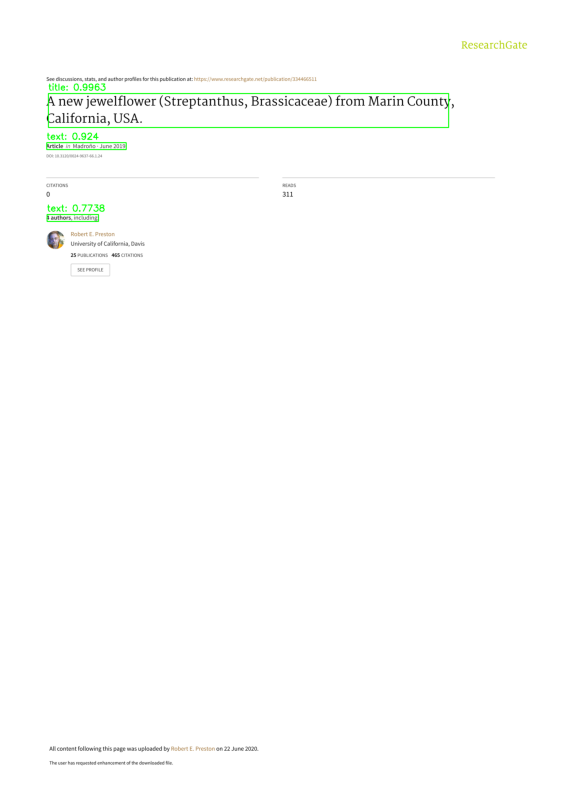

Detected object of label=title with score=0.9995 and in box={x=130, y=437, w=1048, h=120}
Detected object of label=text with score=0.9579 and in box={x=109, y=1651, w=1131, h=71}
Detected object of label=title with score=0.9517 and in box={x=133, y=675, w=673, h=131}
Detected object of label=text with score=0.8508 and in box={x=111, y=1174, w=1095, h=60}
Detected object of label=text with score=0.8332 and in box={x=103, y=1302, w=1140, h=88}
Detected object of label=title with score=0.8252 and in box={x=120, y=1016, w=1072, h=92}
Detected object of label=text with score=0.8012 and in box={x=131, y=583, w=1004, h=75}


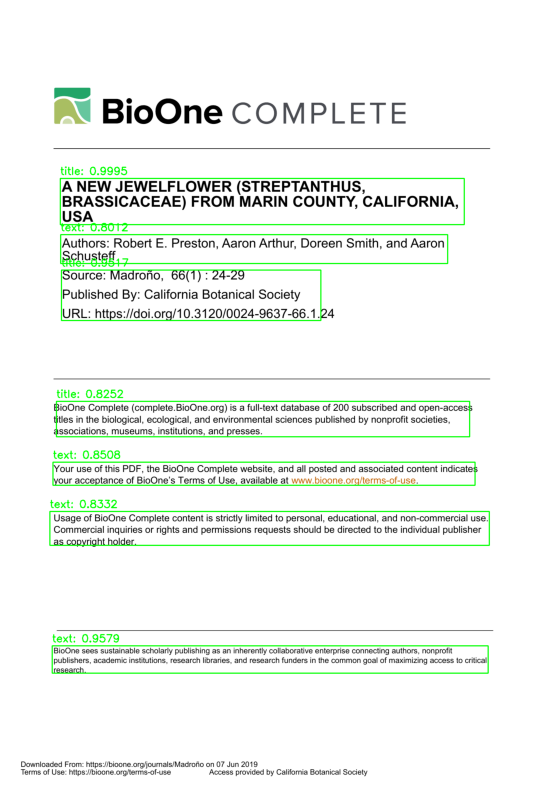

Detected object of label=text with score=0.9999 and in box={x=97, y=923, w=565, h=391}
Detected object of label=text with score=0.9999 and in box={x=94, y=1317, w=567, h=303}
Detected object of label=text with score=0.9997 and in box={x=693, y=988, w=567, h=769}
Detected object of label=text with score=0.9994 and in box={x=97, y=1622, w=562, h=245}
Detected object of label=text with score=0.9983 and in box={x=696, y=1757, w=564, h=113}
Detected object of label=text with score=0.9925 and in box={x=160, y=715, w=1026, h=127}
Detected object of label=title with score=0.9643 and in box={x=95, y=225, w=1171, h=72}
Detected object of label=text with score=0.9599 and in box={x=162, y=854, w=770, h=26}
Detected object of label=text with score=0.9577 and in box={x=564, y=430, w=221, h=29}
Detected object of label=text with score=0.9253 and in box={x=693, y=923, w=568, h=57}
Detected object of label=text with score=0.795 and in box={x=558, y=508, w=223, h=28}
Detected object of label=text with s

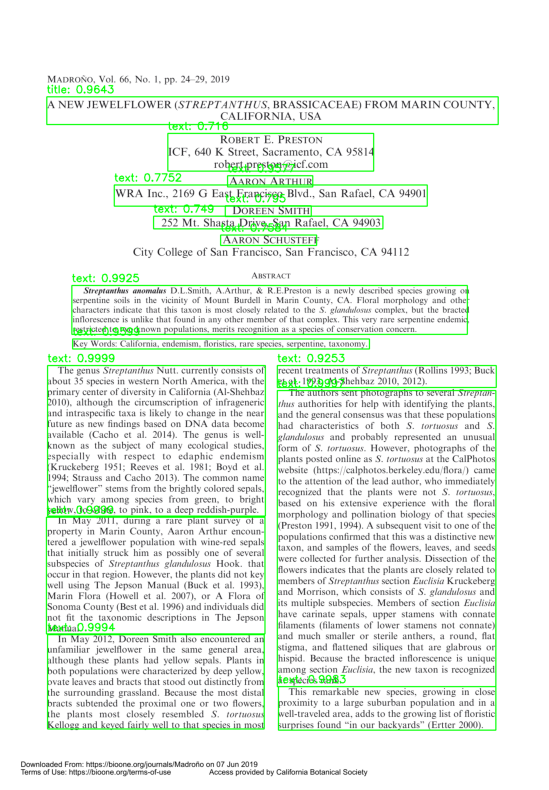

Detected object of label=text with score=1.0 and in box={x=110, y=464, w=568, h=672}
Detected object of label=text with score=0.9998 and in box={x=714, y=167, w=565, h=499}
Detected object of label=text with score=0.9996 and in box={x=716, y=671, w=563, h=1033}
Detected object of label=text with score=0.9992 and in box={x=117, y=1620, w=563, h=247}
Detected object of label=text with score=0.9977 and in box={x=116, y=1144, w=564, h=165}
Detected object of label=text with score=0.9971 and in box={x=116, y=1396, w=561, h=136}
Detected object of label=text with score=0.9944 and in box={x=115, y=360, w=567, h=107}
Detected object of label=title with score=0.9769 and in box={x=157, y=1571, w=480, h=25}
Detected object of label=text with score=0.9545 and in box={x=717, y=1788, w=561, h=84}
Detected object of label=title with score=0.9388 and in box={x=832, y=1738, w=329, h=27}
Detected object of label=text with score=0.8535 and in box={x=131, y=217, w=548, h=141}
Detected object of label=titl

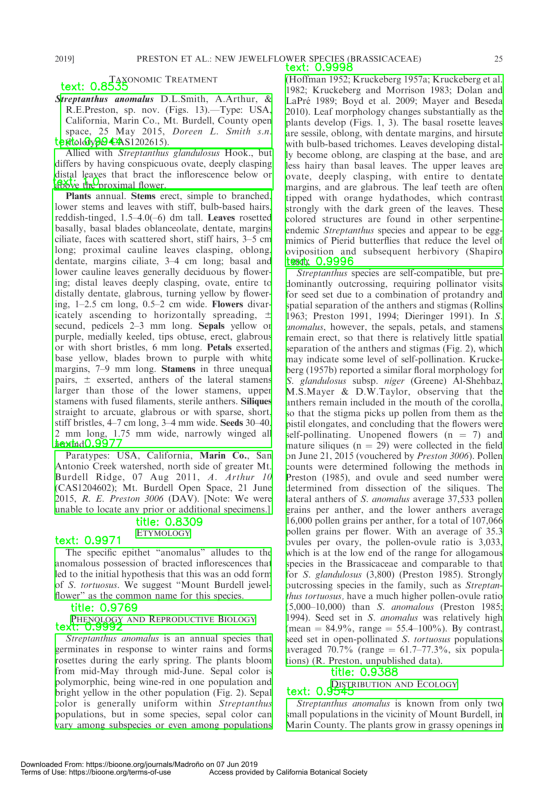

Detected object of label=text with score=0.9982 and in box={x=92, y=1715, w=1169, h=152}
Detected object of label=figure with score=0.9961 and in box={x=117, y=159, w=1137, h=1559}


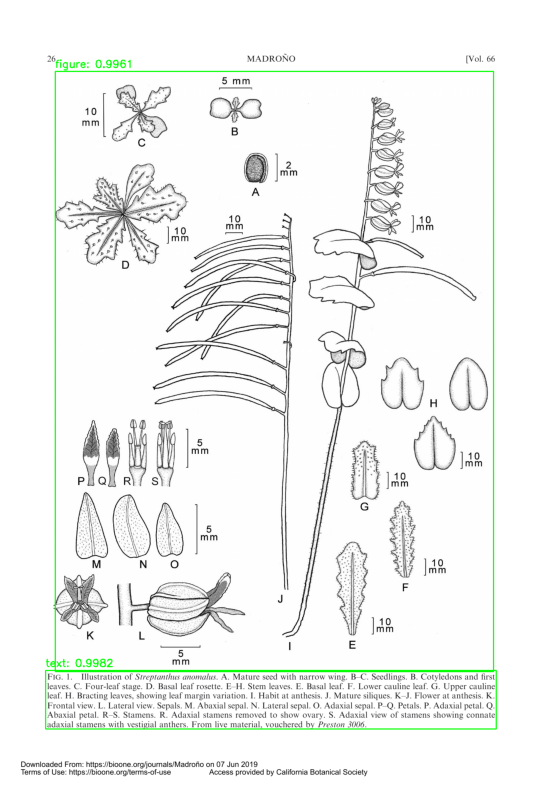

Detected object of label=text with score=0.9998 and in box={x=116, y=930, w=564, h=148}
Detected object of label=text with score=0.9996 and in box={x=110, y=1430, w=573, h=439}
Detected object of label=text with score=0.9996 and in box={x=712, y=938, w=567, h=415}
Detected object of label=text with score=0.9996 and in box={x=112, y=1117, w=565, h=306}
Detected object of label=text with score=0.9992 and in box={x=712, y=598, w=565, h=73}
Detected object of label=figure with score=0.999 and in box={x=712, y=1405, w=570, h=371}
Detected object of label=figure with score=0.999 and in box={x=116, y=165, w=563, h=749}
Detected object of label=figure with score=0.9977 and in box={x=715, y=172, w=558, h=408}
Detected object of label=text with score=0.9966 and in box={x=716, y=1798, w=565, h=71}
Detected object of label=text with score=0.9887 and in box={x=715, y=713, w=563, h=141}
Detected object of label=title with score=0.9565 and in box={x=828, y=886, w=337, h=26}


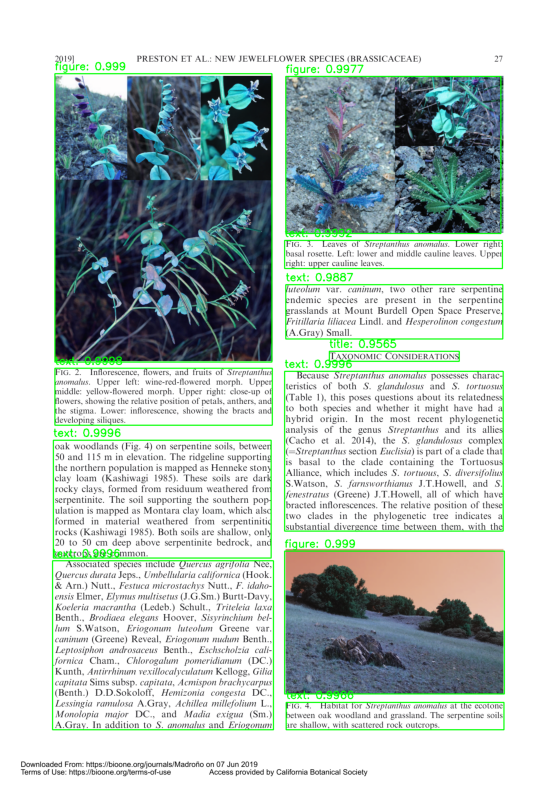

Detected object of label=text with score=1.0 and in box={x=95, y=1178, w=564, h=413}
Detected object of label=text with score=0.9999 and in box={x=692, y=556, w=570, h=476}
Detected object of label=text with score=0.9999 and in box={x=95, y=756, w=563, h=420}
Detected object of label=text with score=0.9998 and in box={x=691, y=1033, w=568, h=363}
Detected object of label=text with score=0.9997 and in box={x=695, y=1469, w=567, h=251}
Detected object of label=text with score=0.9995 and in box={x=94, y=559, w=566, h=194}
Detected object of label=table with score=0.9993 and in box={x=109, y=207, w=1138, h=306}
Detected object of label=text with score=0.9975 and in box={x=97, y=1676, w=565, h=193}
Detected object of label=text with score=0.9942 and in box={x=102, y=168, w=1115, h=23}
Detected object of label=text with score=0.9354 and in box={x=696, y=1793, w=565, h=77}
Detected object of label=title with score=0.925 and in box={x=247, y=1627, w=264, h=26}
Detected object of label=title wi

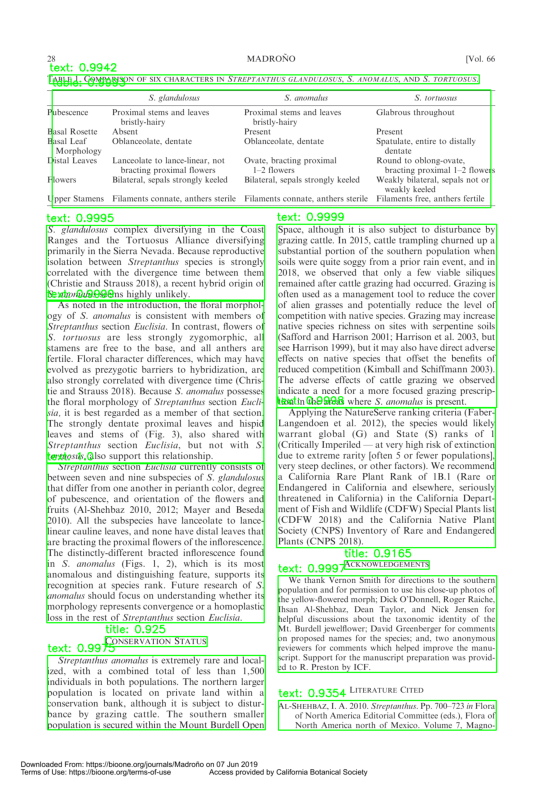

Detected object of label=list with score=0.9973 and in box={x=117, y=172, w=564, h=1482}
Detected object of label=list with score=0.9939 and in box={x=709, y=150, w=565, h=1371}
Detected object of label=text with score=0.8213 and in box={x=123, y=1787, w=558, h=49}
Detected object of label=list with score=0.7346 and in box={x=116, y=1167, w=560, h=649}
Detected object of label=list with score=0.7327 and in box={x=707, y=1163, w=581, h=631}


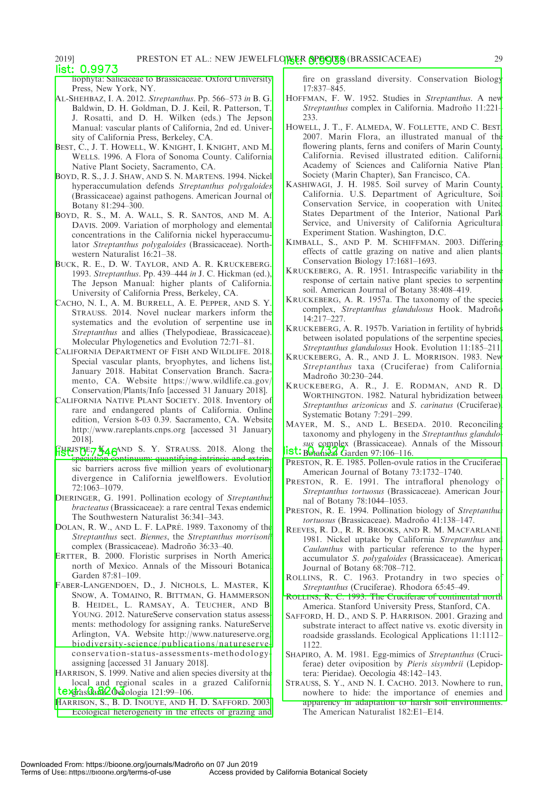

[['title',
  'A new jewelflower (Streptanthus, Brassicaceae) from Marin County\nCalifornia, USA.'],
 ['text', 'Article in Madrofio - June 2019'],
 ['text', '4 authors, includin;'],
 ['title',
  'A NEW JEWELFLOWER (STREPTANTHUS,\nBRASSICACEAE) FROM MARIN COUNTY, CALIFORNIA,\nUSA'],
 ['text',
  'BioOne sees sustainable scholarly publishing as an inherently collaborative enterprise connecting authors, nonprofit\npublishers, academic institutions, research libraries, and research funders in the common goal of maximizing access to critical\nresearch.'],
 ['title',
  'Source: Madrono, 66(1) : 24-29\nPublished By: California Botanical Society\nURL: https://doi.org/10.3120/0024-9637-66.1.'],
 ['text',
  'Your use of this PDF, the BioOne Complete website, and all posted and associated content indicate:\nyour acceptance of BioOne’s Terms of Use, available at www.bioone.org/terms-of-use.'],
 ['text',
  'Usage of BioOne Complete content is strictly limited to personal, educational, and non-commerc

In [5]:
%xmode verbose

pdf_to_elements_advanced(pdf_path, "Detectron2", display= True)

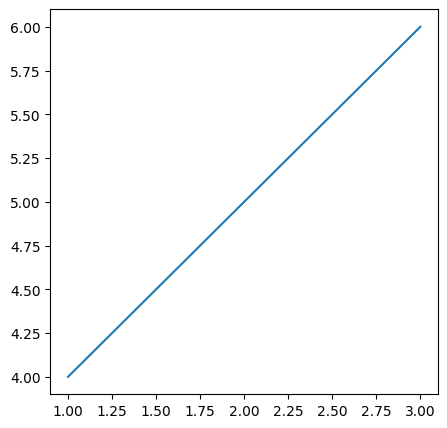

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.plot([1, 2, 3], [4, 5, 6])
plt.show()